# Rock-Paper-Scissors Gesture Classification Pipeline

This notebook demonstrates the complete ML pipeline for Rock-Paper-Scissors image classification, including:
- Data preprocessing
- Model creation and training
- Model evaluation with multiple metrics
- Model optimization techniques


In [1]:
# Import necessary libraries
import sys
import os
sys.path.append('../src')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras

from preprocessing import ImagePreprocessor
from model import RPSModel
from prediction import Predictor

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")


Libraries imported successfully!
TensorFlow version: 2.20.0
Keras version: 3.12.0


## 1. Data Acquisition and Exploration


In [2]:
# Define data paths
train_dir = '../data/raw/train'
test_dir = '../data/raw/test'

# Check data structure
print("Training data structure:")
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        num_images = len([f for f in os.listdir(class_path) if f.endswith(('.png', '.jpg', '.jpeg'))])
        print(f"  {class_name}: {num_images} images")

print("\nTest data structure:")
for class_name in os.listdir(test_dir):
    class_path = os.path.join(test_dir, class_name)
    if os.path.isdir(class_path):
        num_images = len([f for f in os.listdir(class_path) if f.endswith(('.png', '.jpg', '.jpeg'))])
        print(f"  {class_name}: {num_images} images")


Training data structure:
  paper: 840 images
  rock: 840 images
  scissors: 840 images

Test data structure:
  paper: 124 images
  rock: 124 images
  scissors: 124 images


## 2. Data Preprocessing


In [3]:
# Initialize preprocessor
preprocessor = ImagePreprocessor(img_size=(150, 150), normalize=True)

# Load training and test data
print("Loading training data...")
X_train, y_train, X_test, y_test = preprocessor.prepare_training_data(train_dir, test_dir)

print(f"\nTraining data shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Test labels shape: {y_test.shape}")

# Get class names
class_names = preprocessor.get_class_names()
print(f"\nClass names: {class_names}")

# Display class distribution
unique, counts = np.unique(y_train, return_counts=True)
print("\nTraining set class distribution:")
for idx, count in zip(unique, counts):
    print(f"  {class_names[idx]}: {count} images")

unique_test, counts_test = np.unique(y_test, return_counts=True)
print("\nTest set class distribution:")
for idx, count in zip(unique_test, counts_test):
    print(f"  {class_names[idx]}: {count} images")


Loading training data...
Loading training data...
Loading test data...

Training data shape: (2520, 150, 150, 3)
Training labels shape: (2520,)
Test data shape: (372, 150, 150, 3)
Test labels shape: (372,)

Class names: [np.str_('paper'), np.str_('rock'), np.str_('scissors')]

Training set class distribution:
  paper: 840 images
  rock: 840 images
  scissors: 840 images

Test set class distribution:
  paper: 124 images
  rock: 124 images
  scissors: 124 images


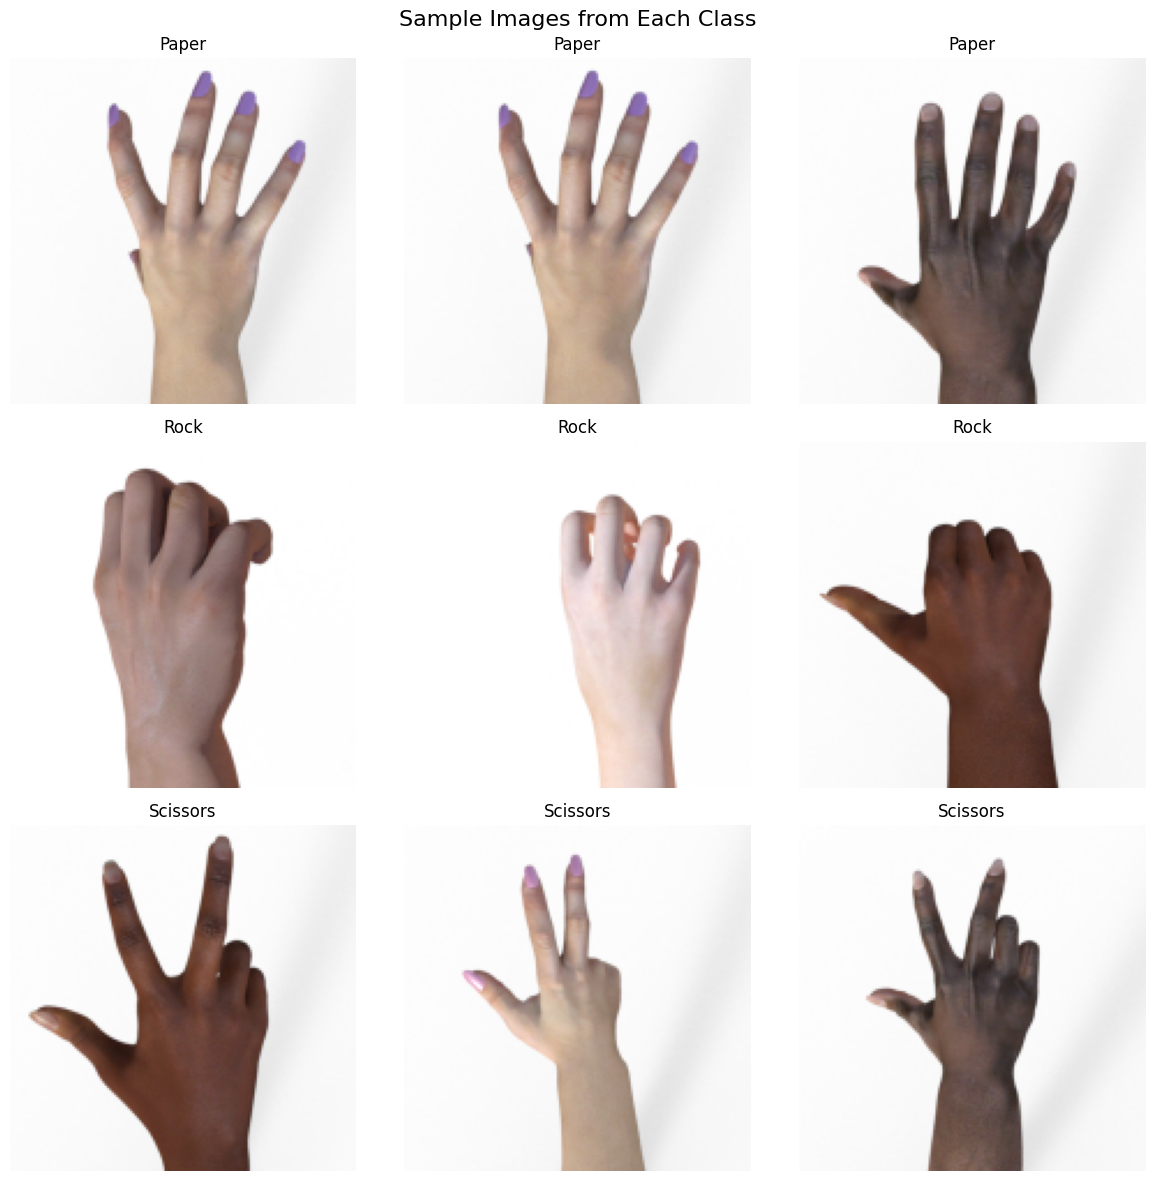

In [4]:
# Visualize sample images
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
fig.suptitle('Sample Images from Each Class', fontsize=16)

for class_idx, class_name in enumerate(class_names):
    # Find indices for this class
    class_indices = np.where(y_train == class_idx)[0]
    
    # Display 3 random samples
    sample_indices = np.random.choice(class_indices, 3, replace=False)
    
    for i, idx in enumerate(sample_indices):
        axes[class_idx, i].imshow(X_train[idx])
        axes[class_idx, i].set_title(f'{class_name.capitalize()}')
        axes[class_idx, i].axis('off')

plt.tight_layout()
plt.show()


## 3. Model Creation and Training


In [5]:
# Create model instance
rps_model = RPSModel(img_size=(150, 150), num_classes=3)

# Build model with transfer learning (MobileNetV2)
print("Building model with transfer learning...")
model = rps_model.build_model(use_transfer_learning=True)

# Display model architecture
model.summary()


Building model with transfer learning...


/Users/abizera/Documents/ALU/ML/ml-pipeline/rps-gesture-pipeline/notebook/../src/model.py:48: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [6]:
# Train the model with optimization techniques
print("Training model...")
print("Using optimization techniques:")
print("  - Early Stopping: Prevents overfitting")
print("  - Learning Rate Reduction: Adapts learning rate during training")
print("  - Model Checkpointing: Saves best model")
print("  - Transfer Learning: Uses MobileNetV2 pre-trained weights")

history = rps_model.train(
    X_train, y_train,
    X_val=X_test,
    y_val=y_test,
    epochs=20,
    batch_size=32,
    use_early_stopping=True,
    use_reduce_lr=True
)


Training model...
Using optimization techniques:
  - Early Stopping: Prevents overfitting
  - Learning Rate Reduction: Adapts learning rate during training
  - Model Checkpointing: Saves best model
  - Transfer Learning: Uses MobileNetV2 pre-trained weights
Epoch 1/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.7955 - loss: 0.5500
Epoch 1: val_loss improved from None to 0.30858, saving model to models/best_model.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 15s 150ms/step - accuracy: 0.9262 - loss: 0.2027 - val_accuracy: 0.9032 - val_loss: 0.3086 - learning_rate: 0.0010
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9940 - loss: 0.0223
Epoch 2: val_loss improved from 0.30858 to 0.27824, saving model to models/best_model.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 0.9960 - loss: 0.0156 - val_accuracy: 0.9167 - val_loss: 0.2782 - learning_rate: 0.0010
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9980 - loss: 0.0099
Epoch 3: val_loss improved from 0.27824 to 0.24473, saving model to models/best_model.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 0.9988 - loss: 0.0076 - val_accuracy: 0.9301 - val_loss: 0.2447 - learning_rate: 0.0010
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 1.0000 - loss: 0.0034
Epoch 4: val_loss did not improve from 0.24473
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 1.0000 - loss: 0.0032 - val_accuracy: 0.9328 - val_loss: 0.2484 - learning_rate: 0.0010
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 1.0000 - loss: 0.0036
Epoch 5: val_loss improved from 0.24473 to 0.24092, saving model to models/best_model.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 0.9382 - val_loss: 0.2409 - learning_rate: 0.0010
Epoch 6/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 0.0024
Epoch 6: val_loss did not improve from 0.24092
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.9113 - val_loss: 0.3170 - learning_rate: 0.0010
Epoch 7/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.9995 - loss: 0.0028
Epoch 7: val_loss improved from 0.24092 to 0.13248, saving model to models/best_model.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 0.9992 - loss: 0.0032 - val_accuracy: 0.9489 - val_loss: 0.1325 - learning_rate: 0.0010
Epoch 8/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 0.0012
Epoch 8: val_loss did not improve from 0.13248
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - accuracy: 1.0000 - loss: 8.5321e-04 - val_accuracy: 0.9435 - val_loss: 0.2111 - learning_rate: 0.0010
Epoch 9/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 7.6469e-04
Epoch 9: val_loss did not improve from 0.13248
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 1.0000 - loss: 9.0897e-04 - val_accuracy: 0.9328 - val_loss: 0.2307 - learning_rate: 0.0010
Epoch 10/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 1.0000 - loss: 7.3432e-04
Epoch 10: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 10: val_loss did not improve from 0.13248
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 118ms/step - accuracy: 1.0000 - loss: 5.9986e-04

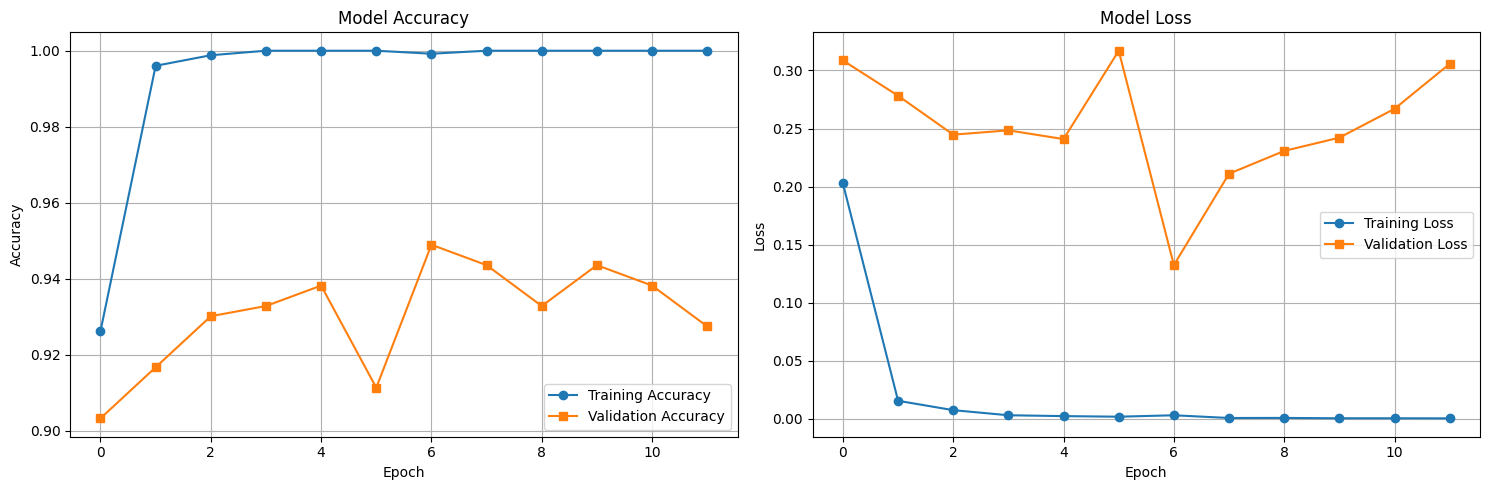

In [7]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy plot
axes[0].plot(history['accuracy'], label='Training Accuracy', marker='o')
axes[0].plot(history['val_accuracy'], label='Validation Accuracy', marker='s')
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Loss plot
axes[1].plot(history['loss'], label='Training Loss', marker='o')
axes[1].plot(history['val_loss'], label='Validation Loss', marker='s')
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


## 4. Model Evaluation


In [8]:
# Evaluate model on test set
print("Evaluating model on test set...")
metrics = rps_model.evaluate(X_test, y_test)

print("\n" + "="*50)
print("MODEL EVALUATION METRICS")
print("="*50)
print(f"Accuracy:  {metrics['accuracy']:.4f} ({metrics['accuracy']*100:.2f}%)")
print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall:    {metrics['recall']:.4f}")
print(f"F1 Score:  {metrics['f1_score']:.4f}")
print(f"Loss:      {metrics['loss']:.4f}")
print("="*50)


Evaluating model on test set...

MODEL EVALUATION METRICS
Accuracy:  0.9489 (94.89%)
Precision: 0.9498
Recall:    0.9489
F1 Score:  0.9484
Loss:      0.1325


In [9]:
# Get detailed predictions
y_pred_proba = rps_model.model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))



Classification Report:
              precision    recall  f1-score   support

       paper       0.96      0.88      0.92       124
        rock       0.92      0.98      0.95       124
    scissors       0.96      0.98      0.97       124

    accuracy                           0.95       372
   macro avg       0.95      0.95      0.95       372
weighted avg       0.95      0.95      0.95       372



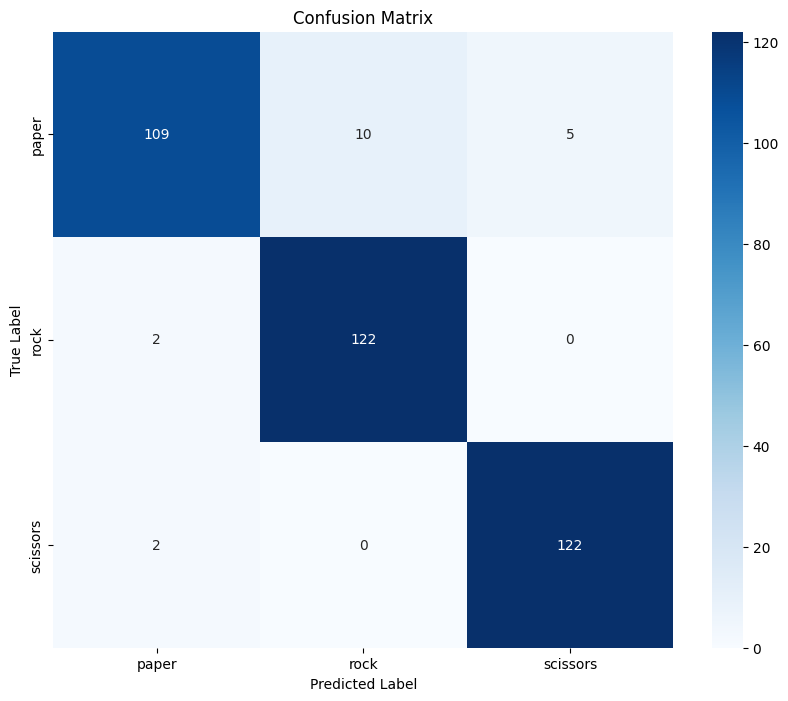


Per-Class Metrics:

Paper:
  Precision: 0.9646
  Recall:    0.8790
  F1 Score:  0.9198

Rock:
  Precision: 0.9242
  Recall:    0.9839
  F1 Score:  0.9531

Scissors:
  Precision: 0.9606
  Recall:    0.9839
  F1 Score:  0.9721


In [10]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Calculate per-class metrics
print("\nPer-Class Metrics:")
for i, class_name in enumerate(class_names):
    tp = cm[i, i]
    fp = cm[:, i].sum() - tp
    fn = cm[i, :].sum() - tp
    tn = cm.sum() - tp - fp - fn
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"\n{class_name.capitalize()}:")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1 Score:  {f1:.4f}")


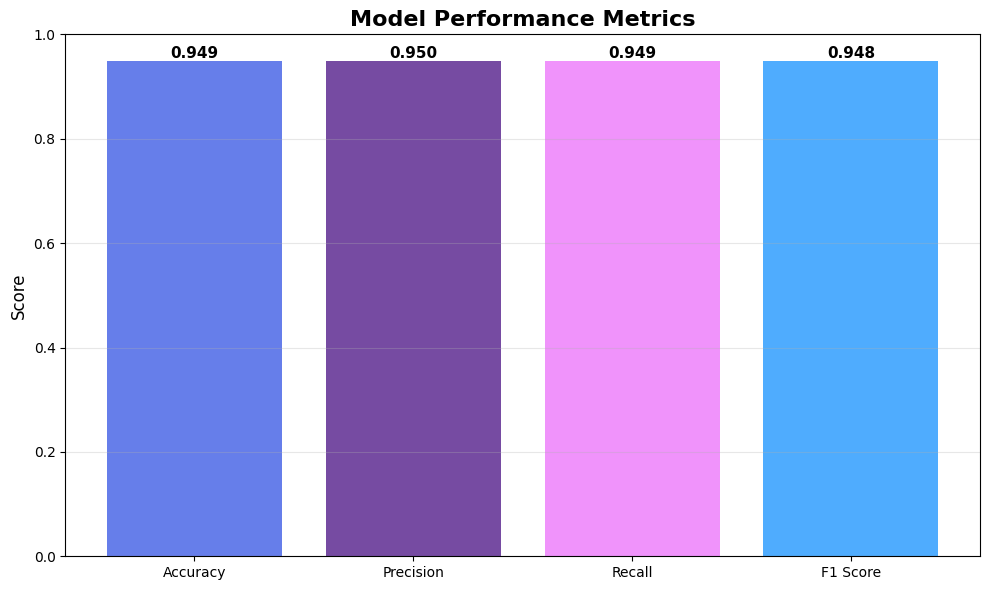

In [11]:
# Visualize metrics comparison
metrics_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Value': [metrics['accuracy'], metrics['precision'], metrics['recall'], metrics['f1_score']]
}

df_metrics = pd.DataFrame(metrics_data)

plt.figure(figsize=(10, 6))
bars = plt.bar(df_metrics['Metric'], df_metrics['Value'], color=['#667eea', '#764ba2', '#f093fb', '#4facfe'])
plt.title('Model Performance Metrics', fontsize=16, fontweight='bold')
plt.ylabel('Score', fontsize=12)
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()


## 5. Model Predictions on Sample Images


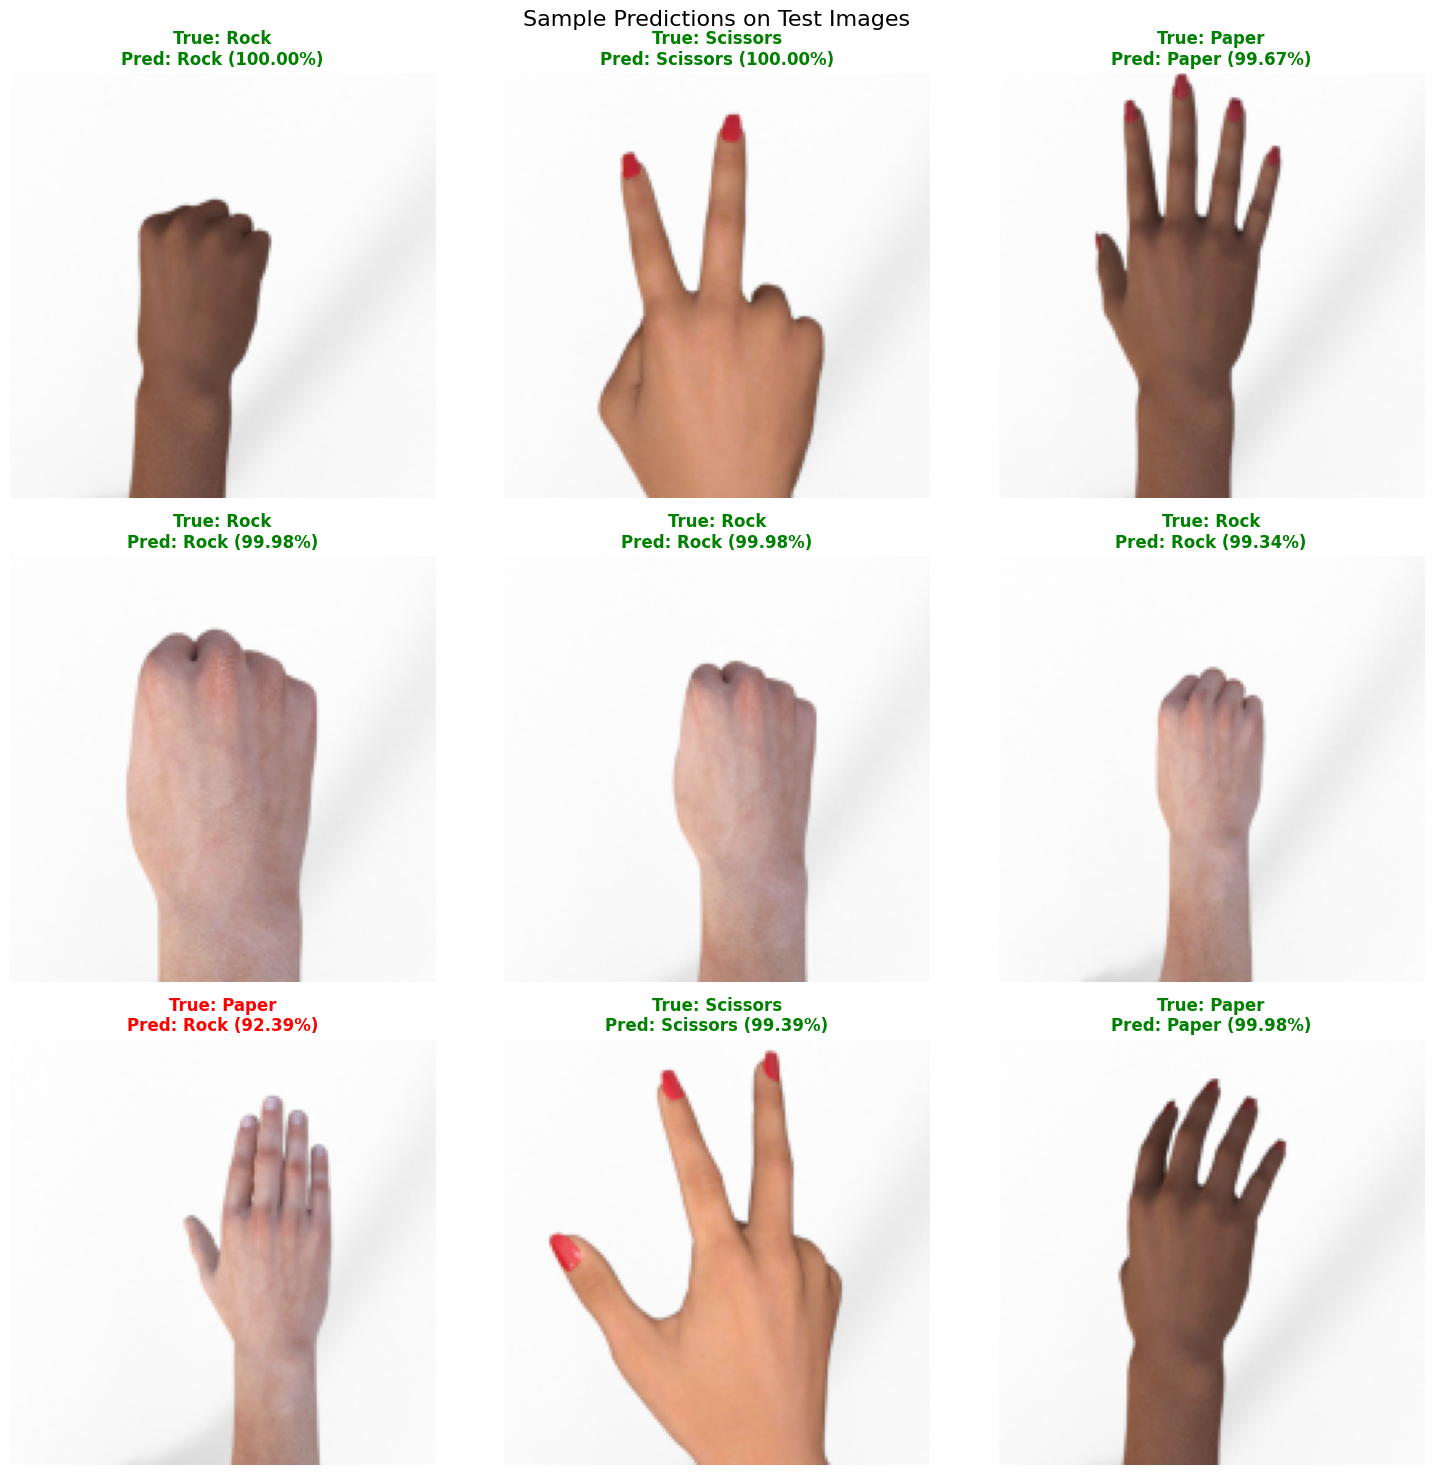

In [12]:
# Test predictions on sample images
predictor = Predictor(rps_model.model, preprocessor, class_names)

# Select random test images
num_samples = 9
sample_indices = np.random.choice(len(X_test), num_samples, replace=False)

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle('Sample Predictions on Test Images', fontsize=16)

for idx, ax in zip(sample_indices, axes.flat):
    # Get prediction
    result = predictor.predict_from_array(X_test[idx:idx+1])
    
    # Display image
    ax.imshow(X_test[idx])
    
    # Get true label
    true_label = class_names[y_test[idx]]
    pred_label = result['predicted_class']
    confidence = result['confidence']
    
    # Color: green if correct, red if incorrect
    color = 'green' if true_label == pred_label else 'red'
    
    ax.set_title(f'True: {true_label.capitalize()}\nPred: {pred_label.capitalize()} ({confidence:.2%})', 
                 color=color, fontweight='bold')
    ax.axis('off')

plt.tight_layout()
plt.show()


## 6. Save Model


In [13]:
# Save the trained model
model_path = '../models/rps_model.h5'
os.makedirs('../models', exist_ok=True)
rps_model.save_model(model_path)

print(f"Model saved successfully to {model_path}")
print(f"\nModel Summary:")
print(f"  - Architecture: MobileNetV2 (Transfer Learning)")
print(f"  - Input Size: 150x150x3")
print(f"  - Number of Classes: 3")
print(f"  - Test Accuracy: {metrics['accuracy']:.4f}")
print(f"  - Test F1 Score: {metrics['f1_score']:.4f}")


Model saved to ../models/rps_model.h5
Model saved successfully to ../models/rps_model.h5

Model Summary:
  - Architecture: MobileNetV2 (Transfer Learning)
  - Input Size: 150x150x3
  - Number of Classes: 3
  - Test Accuracy: 0.9489
  - Test F1 Score: 0.9484


In [14]:
# Save evaluation metrics to JSON so the API can read them
import json
from datetime import datetime
import os

# Compose a serializable metrics payload
metrics_payload = {
    'model_version': datetime.utcnow().strftime('v%Y%m%d_%H%M%S'),
    'accuracy': float(metrics.get('accuracy', None)) if ('metrics' in globals() and metrics is not None) else None,
    'precision': float(metrics.get('precision', None)) if ('metrics' in globals() and metrics is not None) else None,
    'recall': float(metrics.get('recall', None)) if ('metrics' in globals() and metrics is not None) else None,
    'f1_score': float(metrics.get('f1_score', None)) if ('metrics' in globals() and metrics is not None) else None,
    'loss': float(metrics.get('loss', None)) if ('metrics' in globals() and metrics is not None) else None,
    'class_names': list(class_names) if 'class_names' in globals() else None,
    'timestamp': datetime.utcnow().isoformat()
}

# Ensure models directory exists and write the JSON file
os.makedirs('../models', exist_ok=True)
metrics_path = '../models/metrics.json'
with open(metrics_path, 'w') as f:
    json.dump(metrics_payload, f, indent=2)

print(f'Saved metrics JSON to {metrics_path}')

Saved metrics JSON to ../models/metrics.json


/var/folders/0y/x90jhr_15jl2z20gltt_p_dw0000gp/T/ipykernel_39594/1143684271.py:8: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  'model_version': datetime.utcnow().strftime('v%Y%m%d_%H%M%S'),
/var/folders/0y/x90jhr_15jl2z20gltt_p_dw0000gp/T/ipykernel_39594/1143684271.py:15: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  'timestamp': datetime.utcnow().isoformat()


In [15]:
# Save dataset distribution, image size distribution, and class balance to JSON
import os
import json
from datetime import datetime
import numpy as np

# PIL is optional fallback if arrays are not available
try:
    from PIL import Image
except Exception:
    Image = None

models_dir = '../models'
os.makedirs(models_dir, exist_ok=True)

# 1) Dataset distribution (train/test)
dataset_distribution = {'train': {}, 'test': {}}
if 'y_train' in globals() and 'class_names' in globals():
    unique, counts = np.unique(y_train, return_counts=True)
    for u, c in zip(unique, counts):
        dataset_distribution['train'][class_names[int(u)]] = int(c)
if 'y_test' in globals() and 'class_names' in globals():
    unique, counts = np.unique(y_test, return_counts=True)
    for u, c in zip(unique, counts):
        dataset_distribution['test'][class_names[int(u)]] = int(c)

# Fallback to scanning folders if needed
if not dataset_distribution['train'] or not dataset_distribution['test']:
    train_dir = '../data/raw/train'
    test_dir = '../data/raw/test'
    if not dataset_distribution['train'] and os.path.exists(train_dir):
        for class_name in os.listdir(train_dir):
            class_path = os.path.join(train_dir, class_name)
            if os.path.isdir(class_path):
                num = len([f for f in os.listdir(class_path) if f.lower().endswith(('.png','.jpg','.jpeg'))])
                dataset_distribution['train'][class_name] = int(num)
    if not dataset_distribution['test'] and os.path.exists(test_dir):
        for class_name in os.listdir(test_dir):
            class_path = os.path.join(test_dir, class_name)
            if os.path.isdir(class_path):
                num = len([f for f in os.listdir(class_path) if f.lower().endswith(('.png','.jpg','.jpeg'))])
                dataset_distribution['test'][class_name] = int(num)

# 2) Image size distribution (HxW counts)
def get_size_hist_from_arrays(X):
    sizes = {}
    try:
        for img in X:
            h = int(img.shape[0])
            w = int(img.shape[1])
            key = f'{h}x{w}'
            sizes[key] = sizes.get(key, 0) + 1
    except Exception:
        pass
    return sizes

image_size_distribution = {'train': {}, 'test': {}}
if 'X_train' in globals() and getattr(X_train, 'shape', None) is not None:
    image_size_distribution['train'] = get_size_hist_from_arrays(X_train)
if 'X_test' in globals() and getattr(X_test, 'shape', None) is not None:
    image_size_distribution['test'] = get_size_hist_from_arrays(X_test)

# Fallback: scan files and use PIL to get sizes
def scan_sizes_in_dir(dirpath):
    sizes = {}
    if Image is None:
        return sizes
    for root, dirs, files in os.walk(dirpath):
        for fname in files:
            if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                p = os.path.join(root, fname)
                try:
                    with Image.open(p) as im:
                        w, h = im.size
                        key = f'{h}x{w}'
                        sizes[key] = sizes.get(key, 0) + 1
                except Exception:
                    continue
    return sizes

if (not image_size_distribution['train'] or not image_size_distribution['test']):
    train_dir = '../data/raw/train'
    test_dir = '../data/raw/test'
    if not image_size_distribution['train'] and os.path.exists(train_dir):
        image_size_distribution['train'] = scan_sizes_in_dir(train_dir)
    if not image_size_distribution['test'] and os.path.exists(test_dir):
        image_size_distribution['test'] = scan_sizes_in_dir(test_dir)

# 3) Class balance: counts + percentages
def compute_balance(dist):
    total = sum(dist.values()) if dist else 0
    out = {}
    for k, v in dist.items():
        out[k] = {'count': int(v), 'percent': round((v / total * 100) if total > 0 else 0, 2)}
    return out

class_balance = {'train': compute_balance(dataset_distribution.get('train', {})), 'test': compute_balance(dataset_distribution.get('test', {}))}

# Compose output and save
output = {
    'dataset_distribution': dataset_distribution,
    'image_size_distribution': image_size_distribution,
    'class_balance': class_balance,
    'timestamp': datetime.utcnow().isoformat()
}

out_path = os.path.join(models_dir, 'visualization_metrics.json')
with open(out_path, 'w') as fout:
    json.dump(output, fout, indent=2)

print(f'Saved visualization metrics to {out_path}')

Saved visualization metrics to ../models/visualization_metrics.json


/var/folders/0y/x90jhr_15jl2z20gltt_p_dw0000gp/T/ipykernel_39594/2419717706.py:104: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  'timestamp': datetime.utcnow().isoformat()
